## Perceptron

As we have discussed, perceptron allows you to solve **binary classification problem**, i.e. to classify input examples into two classes - we can call them **positive** and **negative**.

First, let's import some required libraries.

In [1]:
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

In [3]:
%pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.8 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


## Toy Problem

To begin with, let's start with a toy problem, where we have two input features. For example, in medicine we may want to classify tumours into benign and malignant, depending on its size and age.

We will generate a random classification dataset using `make_classification` function from SciKit Learn library:

In [2]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # convert initial 0/1 values into -1/1
X = X.astype(np.float32); Y = Y.astype(np.int32) # features - float, label - int

# Split the dataset into training and test
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Labels:
 [-1 -1  1 -1]


Let's also plot the dataset:

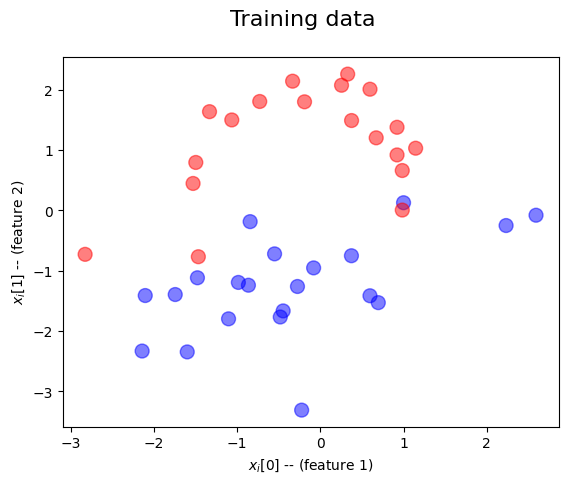

In [3]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Training data', train_x, train_labels)

## Perceptron

Since perceptron is a binary classifier, for each input vector $x$ the output of our perceptron would be either +1 or -1, depending on the class. The output will be computed using the formula

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

where $\mathbf{w}$ is a weight vector, $f$ is a step activation function:
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

However, a generic linear model should also have a bias, i.e. ideally we should compute $y$ as $y=f(\mathbf{w}^{\mathrm{T}}\mathbf{x}+\mathbf{b})$. To simplify our model, we can get rid of this bias term by adding one more dimension to our input features, which always equals to 1:

In [4]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


## Training Algorithm

In order to train the perceptron, we need to find out weights $\mathbf{w}$ that will minimize the error. The error is defined using **perceptron criteria**:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$
 
  * $t_{n} \in \{-1, +1\}$ for negative and positive training samples, respectively
  * $\mathcal{M}$ - a set of wrongly classified examples
  
We will use the process of **gradient descent**. Starting with some initial random weights $\mathbf{w}^{(0)}$, we will adjust weights on each step of the training using the gradient of $E$:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta\sum_{n \in \mathcal{M}}\mathbf{x}_{n} t_{n}$$

where $\eta$ is a **learning rate**, and $\tau\in\mathbb{N}$ - number of iteration.

Let's define this algorithm in Python:

In [5]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    
    # Initialize weights. 
    # We initialize with 0 for simplicity, but random initialization is also a good idea
    weights = np.zeros((num_dims,1)) 
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        # Pick one positive and one negative example
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0: # positive example was classified as negative
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0: # negative example was classified as positive
            weights = weights - neg.reshape(weights.shape)
            
        # Periodically, print out the current accuracy on all examples 
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

Now let's run the training on our dataset:

In [11]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

#결과를 보면 처음 점점 좋아지다가 안 좋아짐

Iteration=0, pos correct=0.7894736842105263, neg correct=0.8571428571428571
Iteration=10, pos correct=0.8947368421052632, neg correct=0.8571428571428571
Iteration=20, pos correct=0.8421052631578947, neg correct=1.0
Iteration=30, pos correct=0.8421052631578947, neg correct=0.9523809523809523
Iteration=40, pos correct=0.8421052631578947, neg correct=1.0
Iteration=50, pos correct=0.8421052631578947, neg correct=0.9523809523809523
Iteration=60, pos correct=0.9473684210526315, neg correct=0.9523809523809523
Iteration=70, pos correct=0.8421052631578947, neg correct=1.0
Iteration=80, pos correct=0.8421052631578947, neg correct=0.5714285714285714
Iteration=90, pos correct=0.8421052631578947, neg correct=1.0
[[-3.24589437  4.50348678  0.        ]]


As you can see, initial accuracy is around 50%, but it quickly increases to higher values close to 90%.

Let's visualize how classes are separated. Our classification function looks like $\mathbf{w}^Tx$, and it is greater than 0 for one class, and is below 0 for another. Thus, class separation line is defined by $\mathbf{w}^Tx = 0$. Since we have only two dimensions $x_0$ and $x_1$, the equation for the line would be $w_0x_0+w_1x_1+w_2 = 0$ (remember that we have explicitly defined an extra dimension $x_2=1$). Let's plot this line:

In [12]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

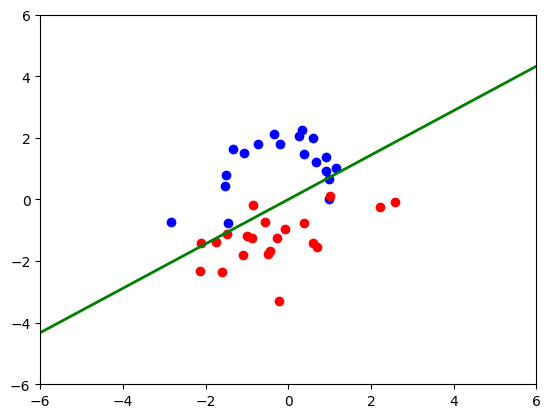

In [14]:
plot_boundary(pos_examples,neg_examples,wts)
#위에 있는 빨간 점은 잘못된 거 

## Evaluate on Test Dataset

In the beginning, we have put apart some data to the test dataset. Let's see how accurate our classifier is on this test dataset. In order to do this, we also expand the test dataset with an extra dimension, multiply by weights matrix, and make sure that the obtained value is of the same sign as the label (+1 or -1). We then add together all boolean values and divide by the length of test sample, to obtain the accuracy:

In [17]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

#결과가 1.0은 .. 실제에선 잘못된 결과 
#트렌인 합쳐도 1이 안 나오는데 test 데이터 돌리면 .... ?
# 신뢰도가 없는 거 ...
# 중간 검증을 돌리는 게 중요함 !! (밸류데이션)
# 테스트 보다 좋게 나오는 건 .. 음 ..... ㅜㅜ

0.9

## Observing the training process

We have seen before how the accuracy decreases during training. It would be nice to see how the separation line behaves during training. The code below will visualize everything on one graph, and you should be able to move the slider to "time-travel" through the training process. 

In [10]:
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 15;
    snapshots = []
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            snapshots.append((np.copy(weights),(pos_correct+neg_correct)/2.0))

    return np.array(snapshots)

snapshots = train_graph(pos_examples,neg_examples)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (7, 2) + inhomogeneous part.

In [18]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

NameError: name 'pl1' is not defined

## Limitations of the Perceptron

As you have seen above, perceptron is a **linear classifier**. It can distinguish between two classes well if they are **linearly separable**, i.e. can be separated by a straight line. Otherwise, perceptron training process will not converge.

A most obvious example of a problem that cannot be solved by a perceptron is so-called **XOR problem**. We want our perceptron to learn the XOR boolean function, which has the following truth table:

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 | 
| 1 | 1 | 0 |

Let's try and do that! We will manually populate all positive and negative training samples, and then call our train function defined above:

In [19]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (67, 2) + inhomogeneous part.

In [14]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl2(step)>

As you can see from the graph above, the accuracy never goes above 75%, because it is impossible to draw a straight line in such a way as to get all possible examples right.

The XOR problem is a classical example of perceptron limitations, and it was pointed out by Marvin Minsky and Seymour Papert in 1969 in their book [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)). This observation limited research in the area of neural networks for almost 10 years, even though - and we will see this in the next section of our course - multi-layered perceptrons are perfectly capable of solving such problems.